# Read the data

In [371]:
from connection import * 
import numpy as np
from sqlalchemy import create_engine 
import psycopg2
import pandas as pd

DB_HOST = DB_HOST
DB_NAME = DB_NAME
DB_USER = DB_USER       
DB_PASS = DB_PASS       
DB_PORT = DB_PORT               # Default PostgreSQL port
 

engine = create_engine(f'postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}')

def get_boolean_columns(engine, schema, table_name):
    query = f"""
        SELECT column_name
        FROM information_schema.columns
        WHERE table_schema = '{schema}' AND table_name = '{table_name}' AND data_type = 'boolean';
    """
    result = pd.read_sql(query, engine)
    return result['column_name'].tolist()

clinical = pd.read_sql('SELECT * FROM project.clinical', engine)
pain = pd.read_sql('SELECT * FROM project.pain', engine)
patient = pd.read_sql('SELECT * FROM project.patient', engine)
psychological = pd.read_sql('SELECT * FROM project.psychological', engine)
radvice = pd.read_sql('SELECT * FROM project.radvice', engine)
work = pd.read_sql('SELECT * FROM project.work', engine)

In [372]:
def convert_bool_to_int(table, engine, table_name):    
    # Recupera colonne booleane vere da PostgreSQL
    bool_cols = get_boolean_columns(engine, 'project', table_name)
    print(bool_cols)
    # Convertili subito in int64 (1/0 + NaN) o float se preferisci
    for col in bool_cols:
        table[col] = table[col].astype(float)  # oppure .astype(float)
    return table

clinical = convert_bool_to_int(clinical, engine, 'clinical')
pain = convert_bool_to_int(pain, engine, 'pain')
patient = convert_bool_to_int(patient, engine, 'patient')
psychological = convert_bool_to_int(psychological, engine, 'psychological')
radvice = convert_bool_to_int(radvice, engine, 'radvice')
work = convert_bool_to_int(work, engine, 'work')

['fever', 'uses_analgesics', 'uses_corticosteroids', 'neurogenic_signals', 'loss_muscle_strength', 'failure_symptoms']
[]
['family_history', 'serious_disease']
['depression', 'stress']
[]
['sick_leave', 'earlier_hospitalization', 'paidwork']


In [373]:
patient.serious_disease.value_counts(dropna=False)

serious_disease
0.0    1076
1.0     455
NaN      12
Name: count, dtype: int64

In [374]:
# Join all the tables
df_merged = radvice.merge(patient, left_on='patient_id', right_on='patient_id', how='left')

# Join: + clinical
df_merged = df_merged.merge(clinical, left_on='clinical_id', right_on='clinical_id', how='left')

# Join: + psychological
df_merged = df_merged.merge(psychological, left_on='psychological_id', right_on='psychological_id', how='left')

# Join: + pain
df_merged = df_merged.merge(pain, left_on='pain_id', right_on='pain_id', how='left')

# Join: + work
df_merged = df_merged.merge(work, left_on='work_id', right_on='work_id', how='left')

df_merged = df_merged.drop(columns=['clinical_id', 'psychological_id', 'pain_id', 'work_id', 'patient_id','treatment_description'])


In [375]:
df_merged.dtypes

treatment                             int64
age                                  object
family_history                      float64
serious_disease                     float64
fever                               float64
uses_analgesics                     float64
uses_corticosteroids                float64
neurogenic_signals                  float64
decreased_mobility                    int64
weightloss_per_year                 float64
loss_muscle_strength                float64
failure_symptoms                    float64
depression                          float64
extremely_nervous                   float64
stress                              float64
irrational_thoughts_risk_lasting    float64
coping_strategy                     float64
kinesiophobia_physical_exercise     float64
kinesiophobia_pain_stop             float64
nocturnal_pain                        int64
continuous_pain                       int64
duration_of_pain                    float64
neck_pain_intensity             

# Data Imputation

In [376]:
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
import numpy as np

# Seleziona solo colonne numeriche
numeric_df = df_merged.select_dtypes(include=['number'])

# Crea X e y
data = numeric_df.values
ix = [i for i in range(data.shape[1]) if i != 0]
X, y = data[:, ix], data[:, 0]

# Check NaN
print('Missing before: %d' % np.isnan(X).sum())

# Pipeline solo con imputer
pipeline = Pipeline(steps=[
    ('imputer', IterativeImputer(max_iter=50, skip_complete=True))
])

pipeline.fit(X)
X_transformed = pipeline.transform(X)

print('Missing after: %d' % np.isnan(X_transformed).sum())

# from sklearn.ensemble import RandomForestClassifier

# # Aggiungi il modello alla pipeline esistente
# pipeline.steps.append(('model', RandomForestClassifier()))

# # Ora puoi fare fit completo
# pipeline.fit(X, y)

Missing before: 500
Missing after: 0


In [377]:
# Ricostruisci il DataFrame con le colonne imputate
X_imputed_df = pd.DataFrame(X_transformed, columns=numeric_df.columns[ix])

# Se vuoi riattaccare la colonna target (y)
X_imputed_df.insert(0, numeric_df.columns[0], y)

# Ora X_imputed_df è il DataFrame completo con le imputazioni
non_numeric_cols = df_merged.select_dtypes(exclude=['number'])
df_final = pd.concat([X_imputed_df, non_numeric_cols.reset_index(drop=True)], axis=1)


# Data Visualizaition

In [378]:
import numpy as np


corr = df_final.drop(columns=['age']).corr()
# Create a mask for the upper triangle
mask = np.triu(np.ones(corr.shape), k=1).astype(bool)

# Apply the mask
corr_masked = corr.mask(mask)

# Style the output
corr_masked.style.background_gradient(cmap='coolwarm')

,treatment,family_history,serious_disease,fever,uses_analgesics,uses_corticosteroids,neurogenic_signals,decreased_mobility,weightloss_per_year,loss_muscle_strength,failure_symptoms,depression,extremely_nervous,stress,irrational_thoughts_risk_lasting,coping_strategy,kinesiophobia_physical_exercise,kinesiophobia_pain_stop,nocturnal_pain,continuous_pain,duration_of_pain,neck_pain_intensity,low_back_pain_intensity,arm_left_pain_intensity,arm_right_pain_intensity,leg_left_pain_intensity,leg_right_pain_intensity,sick_leave,earlier_hospitalization,paidwork
treatment,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
family_history,-0.014436,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
serious_disease,0.108164,-0.307375,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
fever,0.088501,-0.337754,0.808142,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
uses_analgesics,0.016425,0.247421,-0.494150,-0.637445,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
uses_corticosteroids,0.092432,-0.275241,0.717233,0.825982,-0.509908,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
neurogenic_signals,0.052690,-0.076669,0.320983,0.398786,-0.190168,0.319600,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
decreased_mobility,0.052077,0.102522,-0.009118,-0.014339,0.131904,0.010778,0.132110,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
weightloss_per_year,0.005569,-0.035543,-0.031264,0.000153,-0.046662,-0.020399,-0.017006,-0.117831,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
loss_muscle_strength,0.000462,0.037329,0.068132,0.064786,0.071866,0.095545,0.263622,0.096699,0.027095,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [379]:
strong_corr = corr_masked.unstack().dropna()

# Filter for absolute correlations > 0.5 (excluding 1.0)
strong_corr = strong_corr[(strong_corr.abs() > 0.5) & (strong_corr.abs() < 1.0)]

# Sort by strength
strong_corr = strong_corr.sort_values(key=np.abs, ascending=False)
print(strong_corr)

# da valutare quando poi faremo il linear model

fever            uses_corticosteroids    0.825982
serious_disease  fever                   0.808142
                 uses_corticosteroids    0.717233
fever            uses_analgesics        -0.637445
sick_leave       paidwork                0.528568
uses_analgesics  uses_corticosteroids   -0.509908
dtype: float64


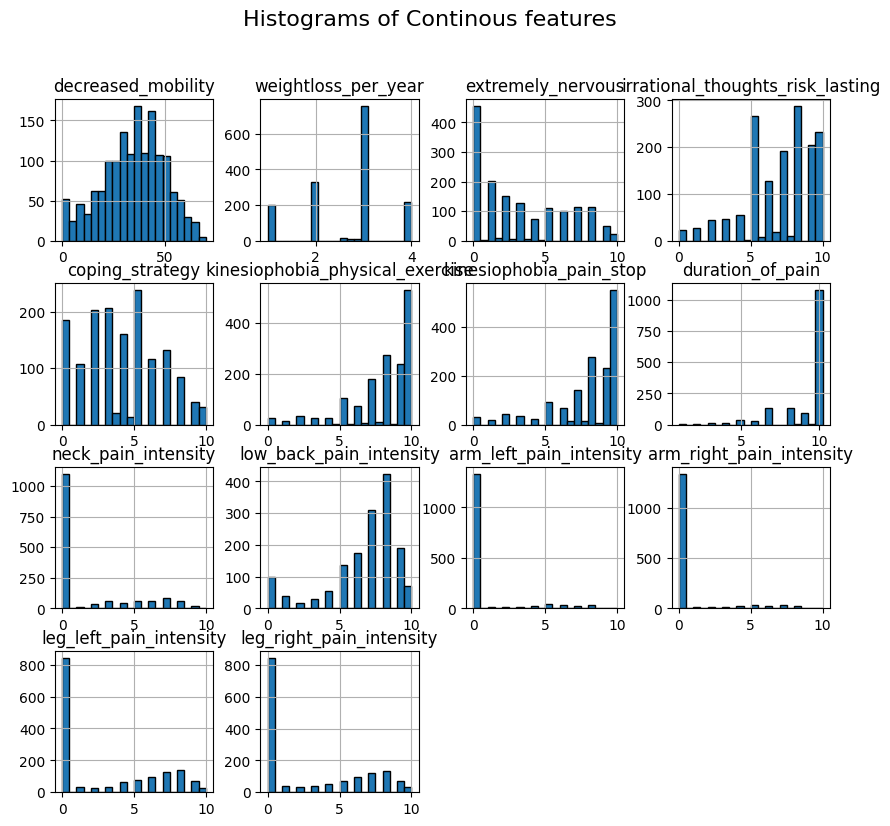

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

In [380]:
numeric_df = df_final.select_dtypes(include=['int64', 'float64', 'Int64'])
numeric_df = numeric_df.loc[:, (numeric_df > 1).any()]
numeric_df = numeric_df.iloc[:,1:]
numeric_df.hist(figsize=(10, 9), bins=20, edgecolor="black")
import matplotlib.pyplot as plt
import seaborn as sns
plt.suptitle("Histograms of Continous features", fontsize=16)
plt.show()

plt.figure(figsize=(20, 10))

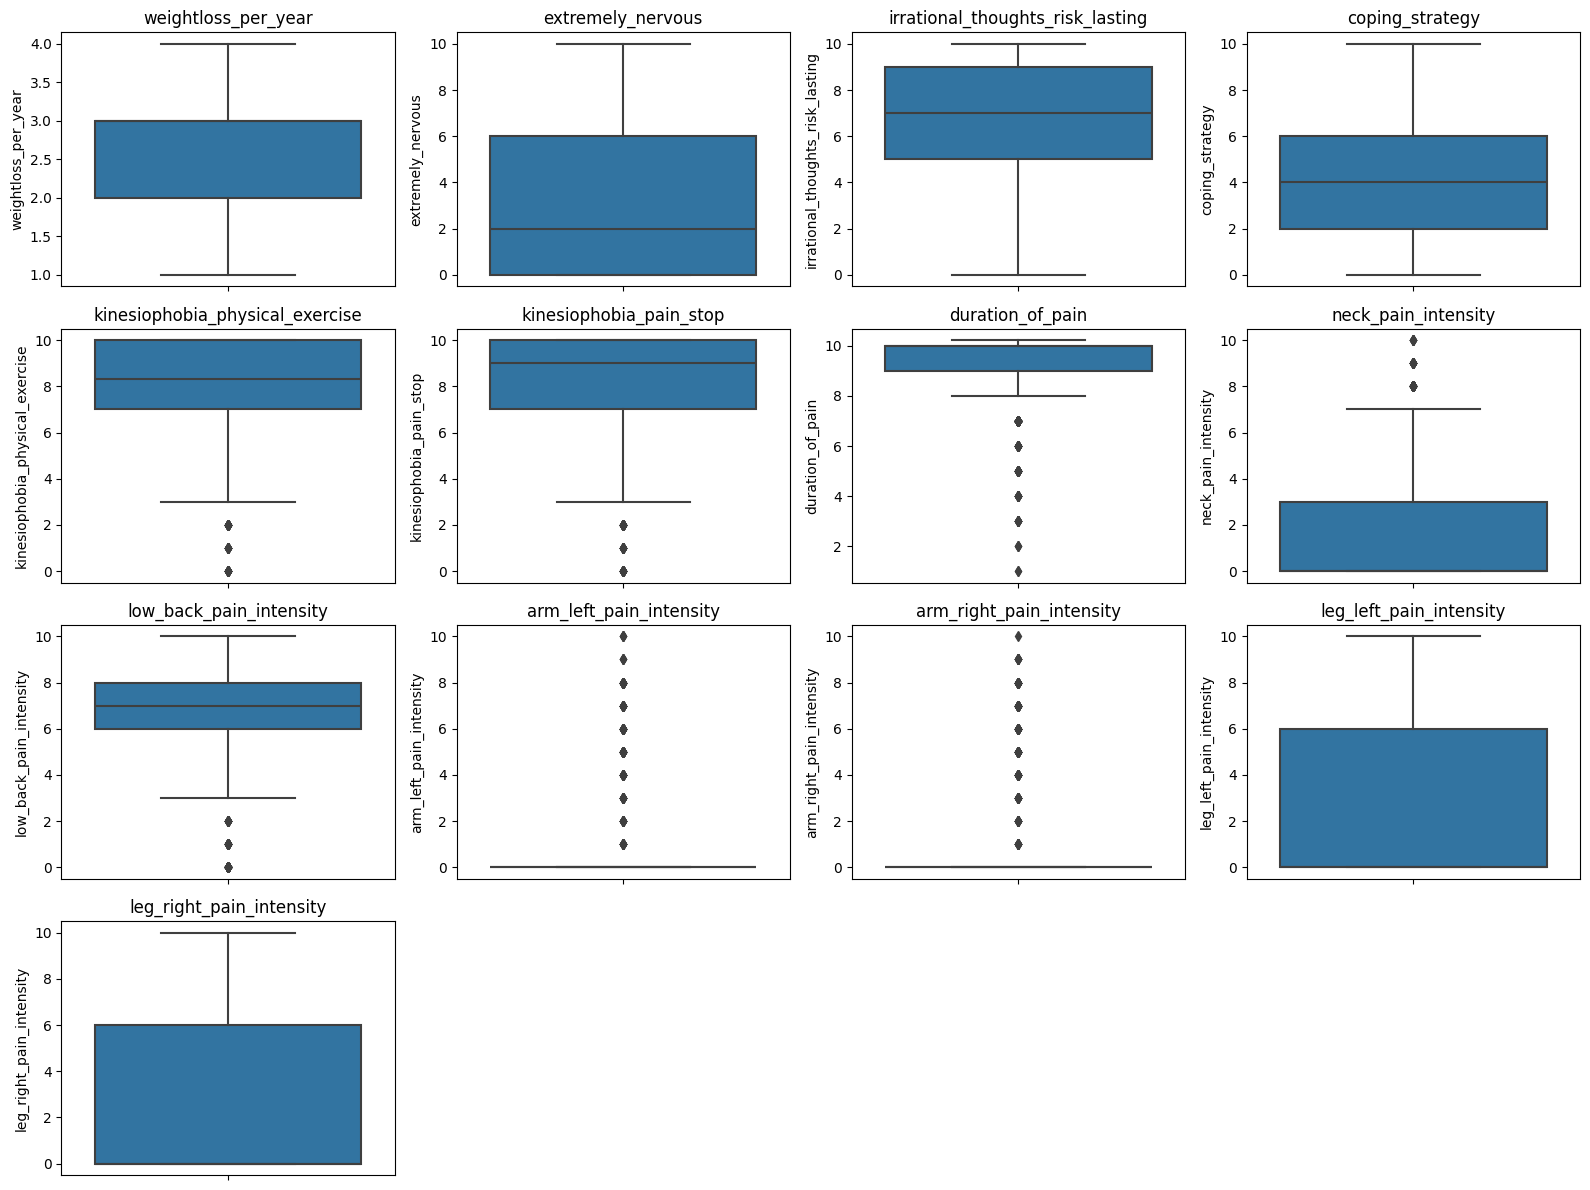

'Considerando le varie distribuzioni ed il n di outliers in __pain sarebbe utile convertire queste features in binarie (got pain, no pain).\n    neck, leg, arm pain'

In [381]:
import math
numeric_df = numeric_df.loc[:, (numeric_df > 1).any()]
numeric_df = numeric_df.iloc[:,1:]
num_cols = len(numeric_df.columns)

# Determine grid size (e.g., square layout)
cols = 4
rows = math.ceil(num_cols / cols)

# Set figure size based on grid size
plt.figure(figsize=(cols * 4, rows * 3))

# Create subplots
for i, col in enumerate(numeric_df.columns, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(y=numeric_df[col])
    plt.title(col)
    plt.tight_layout()

plt.show()


"""Considerando le varie distribuzioni ed il n di outliers in __pain sarebbe utile convertire queste features in binarie (got pain, no pain).
    neck, leg, arm pain"""


In [382]:
df_merged.describe()

,treatment,family_history,serious_disease,fever,uses_analgesics,uses_corticosteroids,neurogenic_signals,decreased_mobility,weightloss_per_year,loss_muscle_strength,...,duration_of_pain,neck_pain_intensity,low_back_pain_intensity,arm_left_pain_intensity,arm_right_pain_intensity,leg_left_pain_intensity,leg_right_pain_intensity,sick_leave,earlier_hospitalization,paidwork
count,1543.000000,1543.000000,1531.000000,1510.000000,1543.000000,1530.000000,1543.000000,1543.000000,1507.000000,1462.000000,...,1515.000000,1543.000000,1543.000000,1543.000000,1543.000000,1543.000000,1543.000000,1543.000000,1543.000000,1543.000000
mean,2.894362,0.256643,0.297191,0.273510,0.561244,0.303268,0.684381,34.473104,2.659589,0.538988,...,9.193399,1.587816,6.525599,0.705120,0.713545,2.805574,2.785483,0.302009,0.692158,0.328581
std,1.867842,0.436922,0.457171,0.445908,0.496396,0.459820,0.464913,15.008096,0.886062,0.498648,...,1.521821,2.760178,2.528276,1.967444,1.993405,3.453759,3.466908,0.459278,0.461750,0.469849
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,2.000000,0.000000,...,9.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,35.000000,3.000000,1.000000,...,10.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,45.000000,3.000000,1.000000,...,10.000000,3.000000,8.000000,0.000000,0.000000,6.000000,6.000000,1.000000,1.000000,1.000000
max,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,70.000000,4.000000,1.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.000000,1.000000


In [383]:
df_final.age.value_counts()

age
50-59    402
60-69    312
40-49    311
30-39    187
70-79    168
20-29    105
>=80      33
0-19      25
Name: count, dtype: int64

# Conversione colonne arm,leg,neck pain in binarie

In [384]:
### Controlla se almeno uno tra sinistro e destro ha intensità > 0
df_final['arm_pain'] = ((df_final['arm_left_pain_intensity'] > 0) | 
                         (df_final['arm_right_pain_intensity'] > 0)).astype('int64')

df_final['leg_pain'] = ((df_final['leg_left_pain_intensity'] > 0) | 
                         (df_final['leg_right_pain_intensity'] > 0)).astype('int64')

df_final['neck_pain'] = ((df_final['neck_pain_intensity'] > 0)).astype('int64')

df_new = df_final.drop(columns={'arm_left_pain_intensity','arm_right_pain_intensity','leg_left_pain_intensity','leg_right_pain_intensity','neck_pain_intensity'})

# passiamo da 34 a 29 colonne
df_new.dtypes

treatment                           float64
family_history                      float64
serious_disease                     float64
fever                               float64
uses_analgesics                     float64
uses_corticosteroids                float64
neurogenic_signals                  float64
decreased_mobility                  float64
weightloss_per_year                 float64
loss_muscle_strength                float64
failure_symptoms                    float64
depression                          float64
extremely_nervous                   float64
stress                              float64
irrational_thoughts_risk_lasting    float64
coping_strategy                     float64
kinesiophobia_physical_exercise     float64
kinesiophobia_pain_stop             float64
nocturnal_pain                      float64
continuous_pain                     float64
duration_of_pain                    float64
low_back_pain_intensity             float64
sick_leave                      

c:\Users\Mardeen\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Mardeen\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


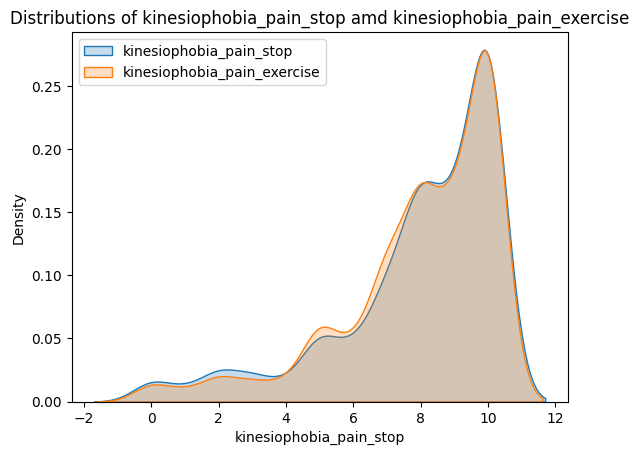

c:\Users\Mardeen\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


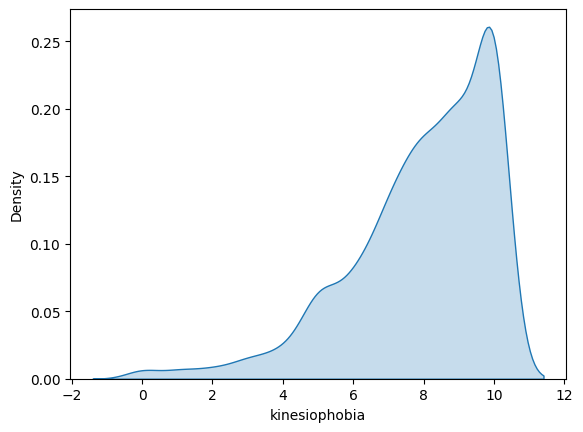

In [385]:
## Verifica distribuzioni di Kinesiophobia
sns.kdeplot(df_new['kinesiophobia_pain_stop'], label='kinesiophobia_pain_stop', fill=True)
sns.kdeplot(df_new['kinesiophobia_physical_exercise'], label='kinesiophobia_pain_exercise', fill=True)
plt.legend()
plt.title("Distributions of kinesiophobia_pain_stop amd kinesiophobia_pain_exercise")
plt.show()

## Creo nuova variabile Kinesiophobia prendendo il valore medio tra le due distribuzioni

df_new['kinesiophobia'] = df_new[['kinesiophobia_pain_stop', 'kinesiophobia_physical_exercise']].mean(axis=1)
sns.kdeplot(df_new['kinesiophobia'], label='kinesiophobia_pain_stop', fill=True)

df_new = df_new.drop(columns={'kinesiophobia_pain_stop','kinesiophobia_physical_exercise'})

In [386]:
df_new.columns

Index(['treatment', 'family_history', 'serious_disease', 'fever',
       'uses_analgesics', 'uses_corticosteroids', 'neurogenic_signals',
       'decreased_mobility', 'weightloss_per_year', 'loss_muscle_strength',
       'failure_symptoms', 'depression', 'extremely_nervous', 'stress',
       'irrational_thoughts_risk_lasting', 'coping_strategy', 'nocturnal_pain',
       'continuous_pain', 'duration_of_pain', 'low_back_pain_intensity',
       'sick_leave', 'earlier_hospitalization', 'paidwork', 'age', 'arm_pain',
       'leg_pain', 'neck_pain', 'kinesiophobia'],
      dtype='object')

Index(['decreased_mobility', 'weightloss_per_year', 'extremely_nervous',
       'irrational_thoughts_risk_lasting', 'coping_strategy',
       'duration_of_pain', 'low_back_pain_intensity', 'kinesiophobia'],
      dtype='object')


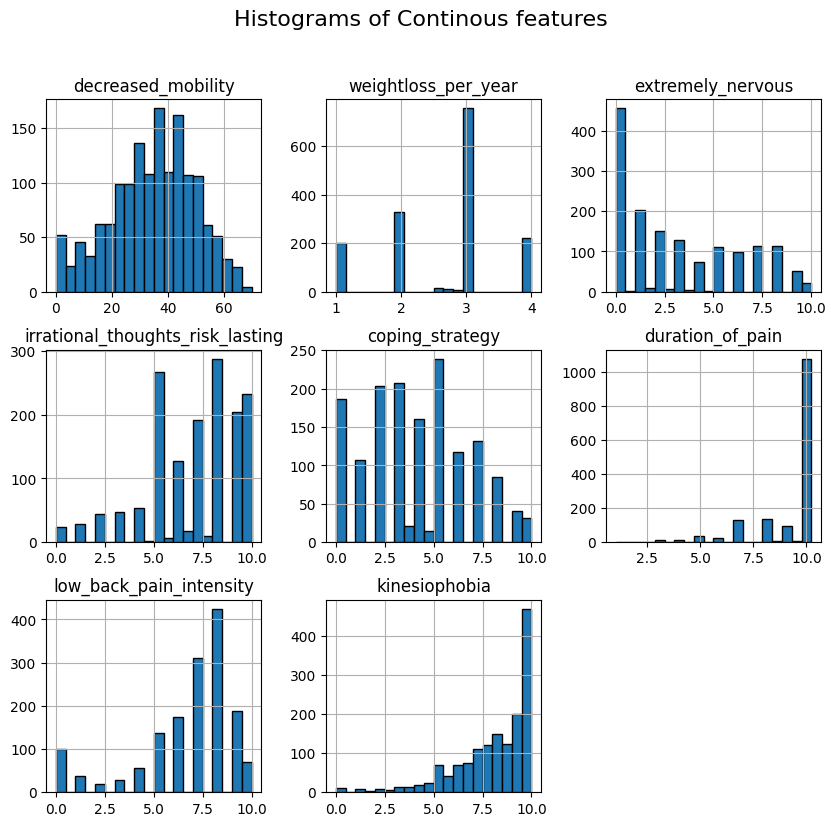

<Figure size 1700x1000 with 0 Axes>

<Figure size 1700x1000 with 0 Axes>

In [387]:
numeric_df = df_new.select_dtypes(include=['int64', 'float64', 'Int64'])
numeric_df = numeric_df.loc[:, (numeric_df > 1).any()]
numeric_df = numeric_df.iloc[:,1:]
print(numeric_df.columns)
numeric_df.hist(figsize=(10, 9), bins=20, edgecolor="black")
import matplotlib.pyplot as plt
import seaborn as sns
plt.suptitle("Histograms of Continous features", fontsize=16)
plt.show()

plt.figure(figsize=(17, 10))

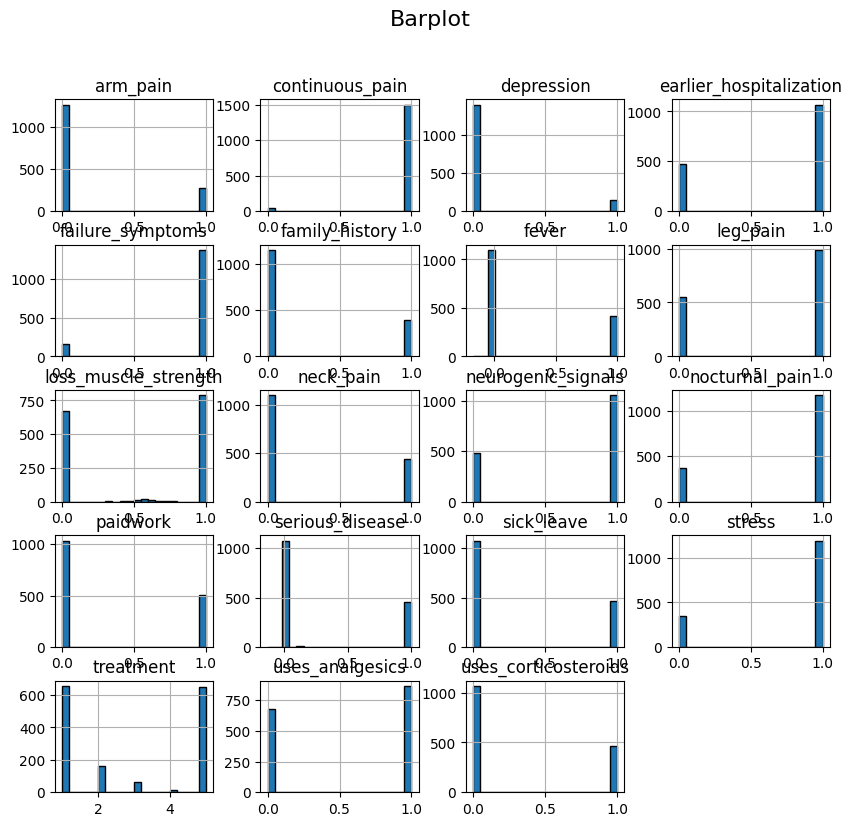

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

In [388]:
# Categorical
plot_df = df_new[df_new.columns.difference(numeric_df.columns)]
plot_df.hist(figsize=(10, 9), bins=20, edgecolor="black")
plt.suptitle("Barplot", fontsize=16)
plt.show()

plt.figure(figsize=(20, 10))

In [389]:
# 1. Convert numeric columns to float
df_new[numeric_df.columns] = df_new[numeric_df.columns].astype(float)

# 2. Identify non-numeric columns (excluding 'age')
non_numeric_cols = df_new.columns.difference(numeric_df.columns).difference(['age'])

# 3. Convert those to Int64
df_new[non_numeric_cols] = df_new[non_numeric_cols].apply(pd.to_numeric, errors='coerce').astype('int64')
df_new.dtypes


treatment                             int64
family_history                        int64
serious_disease                       int64
fever                                 int64
uses_analgesics                       int64
uses_corticosteroids                  int64
neurogenic_signals                    int64
decreased_mobility                  float64
weightloss_per_year                 float64
loss_muscle_strength                  int64
failure_symptoms                      int64
depression                            int64
extremely_nervous                   float64
stress                                int64
irrational_thoughts_risk_lasting    float64
coping_strategy                     float64
nocturnal_pain                        int64
continuous_pain                       int64
duration_of_pain                    float64
low_back_pain_intensity             float64
sick_leave                            int64
earlier_hospitalization               int64
paidwork                        

# Feature Analysis

## Feature Scaling + One-Hot Encoding Age

In [398]:
from sklearn.preprocessing import StandardScaler

# One-hot encode 'age'
#age_encoded = pd.get_dummies(df_new['age'], prefix='age')
age_map = {
    '0-19': 10,
    '20-29': 25,
    '30-39': 35,
    '40-49': 45,
    '50-59': 55,
    '60-69': 65,
    '70-79': 75,
    '>=80': 85
}

df_new['age_numeric'] = df_new['age'].map(age_map)

features_to_use = df_new.drop(columns=['treatment', 'age'])

# Combine with one-hot encoded age
#X = pd.concat([features_to_use.reset_index(drop=True), age_encoded.reset_index(drop=True)], axis=1)
X = features_to_use.reset_index(drop=True)
y = df_new['treatment']

# 4. Standard scale all features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## PCA

In [399]:
### Per Logistic regression e PCA creiamo BINS per age

# One-hot encode 'age' into multiple binary columns
#age_encoded = pd.get_dummies(df_new['age'], prefix='age')
# df_new = pd.concat([df_new.drop(columns='age'), age_encoded], axis=1)
#features_final = df_new.drop(columns=['treatment'])


In [400]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

# 7. Add back treatment (if needed)
pca_df['treatment'] = df_new['treatment'].reset_index(drop=True)


  Principal Component           Top Feature
0                 PC0                 fever
1                 PC1    decreased_mobility
2                 PC2           age_numeric
3                 PC3           age_numeric
4                 PC4              arm_pain
5                 PC5            depression
6                 PC6  loss_muscle_strength
7                 PC7   weightloss_per_year
8                 PC8       continuous_pain
9                 PC9       coping_strategy


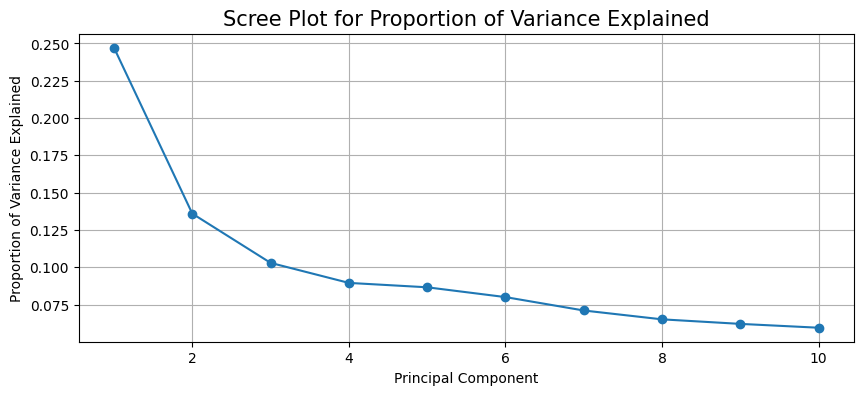

In [401]:
eigenvalues = pca.explained_variance_
prop_var = eigenvalues / np.sum(eigenvalues)
plt.figure(figsize=(10,4))
plt.plot(np.arange(1, len(prop_var)+1), 
                   prop_var, marker='o')
plt.xlabel('Principal Component',
           size = 10)
plt.ylabel('Proportion of Variance Explained',
           size = 10)
plt.title('Scree Plot for Proportion of Variance Explained',
          size = 15)
plt.grid(True)

# loadings (PCA components)
pca_components = pd.DataFrame(
    pca.components_,
    columns=X.columns,
    index=[f'PC{i}' for i in range(pca.n_components_)]
)

# Get most important feature per PC
top_features = pca_components.abs().idxmax(axis=1).reset_index()
top_features.columns = ['Principal Component', 'Top Feature']

print(top_features)

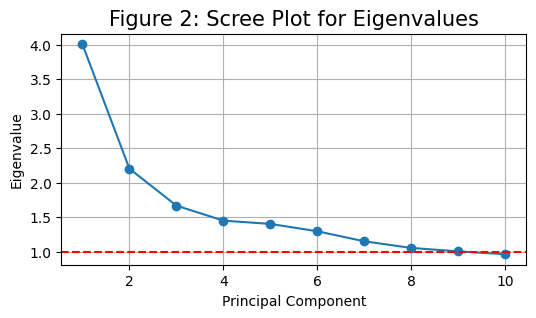

In [402]:
# Secondo il criterio di Kaiser, si considerano solo le componenti con autovalore > 1 → perché spiegano più varianza di una singola variabile originale
# Dal grafico, le prime 4 componenti superano il valore 1
#  le prime 2–4 componenti spiegano la maggior parte dell’informazione

plt.figure(figsize=(6,3))
plt.plot(np.arange(1, len(eigenvalues)+1), 
         eigenvalues, marker='o')
plt.xlabel('Principal Component',
           size = 10)
plt.ylabel('Eigenvalue',
           size = 10)
plt.title('Figure 2: Scree Plot for Eigenvalues',
          size = 15)
plt.axhline(y=1, color='r', 
            linestyle='--')
plt.grid(True)

In [403]:
# PCA with 4 components
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
pca_df['treatment'] = df_new['treatment'].reset_index(drop=True)

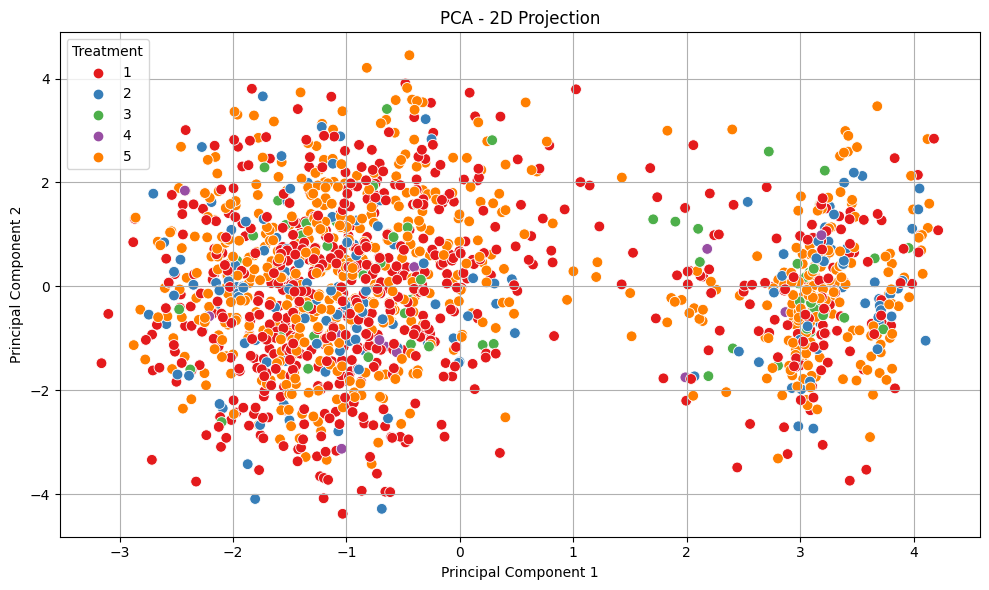

In [404]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Riduci a 2 componenti
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

# Crea un DataFrame con i 2 PC
pca_2d_df = pd.DataFrame(X_pca_2d, columns=['PC1', 'PC2'])
pca_2d_df['treatment'] = df_new['treatment'].reset_index(drop=True)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_2d_df, x='PC1', y='PC2', hue='treatment', palette='Set1', s=60)
plt.title('PCA - 2D Projection')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Treatment')
plt.grid(True)
plt.tight_layout()
plt.show()


# Modeling

# TODO
- un model con tutte features in ultimo df
- un model con features in PCA

## MultiNomial Logit Regression

In [405]:
import statsmodels.api as sm

# Use scaled features or PCA (replace X_scaled with X_pca if needed)
X = pd.DataFrame(X_scaled, columns=features_to_use.columns)  # features_final = all final features used
y = df_new['treatment'].reset_index(drop=True)

# Add intercept for statsmodels
X = sm.add_constant(X)

# Fit logistic regression
logit_model = sm.MNLogit(y, X)
result = logit_model.fit()

print(result.summary())


         Current function value: 1.048894
         Iterations: 35


c:\Users\Mardeen\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                          MNLogit Regression Results                          
Dep. Variable:              treatment   No. Observations:                 1543
Model:                        MNLogit   Df Residuals:                     1431
Method:                           MLE   Df Model:                          108
Date:                Sat, 29 Mar 2025   Pseudo R-squ.:                 0.07592
Time:                        19:19:53   Log-Likelihood:                -1618.4
converged:                      False   LL-Null:                       -1751.4
Covariance Type:            nonrobust   LLR p-value:                 2.508e-15
                     treatment=2       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               -1.6798      0.111    -15.085      0.000      -1.898      -1.462
family_history                       0.0877      0.100      0.879

# Random Forest

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Usare age come variabile continua!!!!!
df_new['age_encoded'] = LabelEncoder().fit_transform(df_new['age'])
